# Lecture 2 Examples
## By James Camacho

In [1]:
# Imports
import numpy as np
import sympy as sp
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

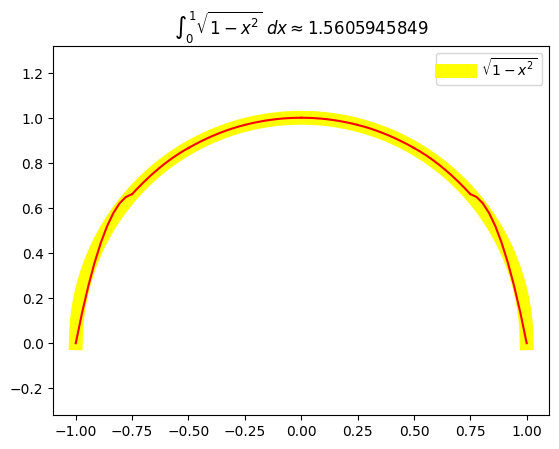

For reference, π/2 =  1.5707963268


In [2]:
# Simpson's rule

def simpson(f, x_start, x_end, dx=0.01):
    integral = 0
    for x in np.arange(x_start, x_end, 2*dx):
        integral += (f(x) + 4 * f(x + dx) + f(x + 2*dx)) * dx / 3
    return integral

def f(x):
    return np.sqrt(1 - x**2)

dx = 1 / 8
integral = simpson(f, -1, 1, dx)

plt.title(r"$\int_{0}^{1} \sqrt{1-x^2}\ dx\approx$" + f"{integral:.10f}")
xrange = np.linspace(-1, 1, 1000)
plt.plot(xrange, f(xrange), label=r"$\sqrt{1-x^2}$", linewidth=10, color="yellow")

xrange = np.linspace(0, 1, 10)
for x in np.arange(-1, 1-0*dx, 2*dx):
    a, b, c = np.polyfit([x, x+dx, x+2*dx], [f(x), f(x+dx), f(x+2*dx)], 2)
    x_ = x + xrange * 2*dx
    plt.plot(x_, a*x_**2 + b*x_ + c, color="red")

plt.legend()
plt.axis("equal")
plt.show()

print(f"For reference, π/2 = {np.pi / 2 : .10f}")

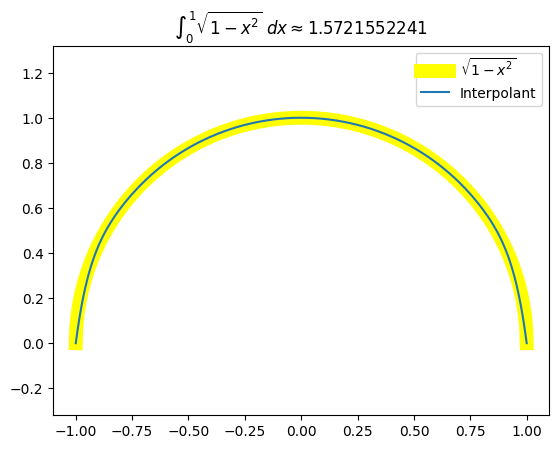

In [3]:
# Gauss-Legendre quadrature
from scipy.special import roots_legendre

def gauss_legendre(f, x_start, x_end, num_points=16):
    x, w = roots_legendre(num_points)
    x = (x_start + x_end) / 2 + x*(x_end - x_start) / 2
    w *= (x_end - x_start) / 2
    return f(x) @ w
    
num_points = 8
integral = gauss_legendre(f, -1, 1, num_points)

plt.title(r"$\int_{0}^{1} \sqrt{1-x^2}\ dx\approx$" + f"{integral:.10f}")
xrange = np.linspace(-1, 1, 1000)

x = np.linspace(-1, 1, 2*num_points)
c = np.polyfit(x, f(x), len(x)-1)[::-1]

plt.plot(xrange, f(xrange), label=r"$\sqrt{1-x^2}$", linewidth=10, color="yellow")
plt.plot(xrange, c @ xrange**(np.arange(2*num_points))[:, None], label="Interpolant")

plt.axis("equal")
plt.legend()
plt.show()

In [4]:
# Finite difference method stencils
def five_point_stencil(dx):
    return np.array([[0, 1,  0],
                     [1, -4, 1],
                     [0, 1,  0]]) / dx**2

def nine_point_stencil(dx):
    return np.array([[1,  4,  1],
                     [4, -20, 4],
                     [1,  4,  1]]) / 6 / dx**2

/home/james/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


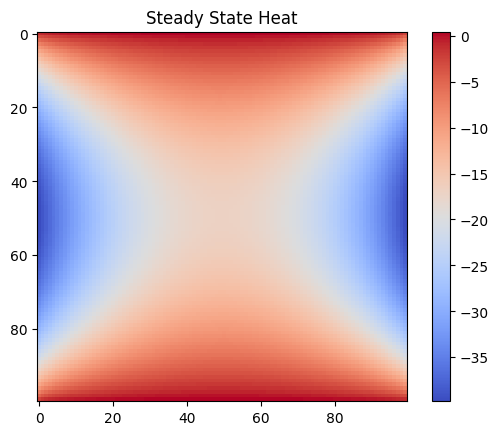

In [5]:
# Dirichlet boundary conditions

def dirichlet_M(stencil, N):
    # Create n+1 x n+1 sparse matrix out of stencil and bdry equations
    dx = 1 / (N - 1)
    s = stencil(dx)
    
    offsets = []
    diags = []
    for i in range(s.shape[1]):
        x = i - s.shape[1] // 2
        for j in range(s.shape[0]):
            if s[i, j] == 0:
                continue
            
            y = j - s.shape[0] // 2
            offset = x + N * y
            offsets.append(offset)
            diags.append(np.repeat(s[i, j], N*N - abs(offset)))
    
    return scipy.sparse.diags(diags, offsets)

def dirichlet_b(stencil, N):
    b = np.zeros((N, N))
    
    # Add in boundary conditions
    s = stencil(1 / (N - 1))
    for i in range(s.shape[1]):
        for j in range(s.shape[0]):
            # Make hot horizontal boundaries
            for x in range(N):
                if j < s.shape[0] // 2:
                    b[0, x] -= s[i, j]
                if j > s.shape[0] // 2:
                    b[-1, x] -= s[i, j]
            # Make cold vertical boundaries
            for y in range(N):
                if i < s.shape[1] // 2:
                    b[y, 0] += s[i, j]
                if i > s.shape[1] // 2:
                    b[y, -1] += s[i, j]
    
    return b.flatten()

N = 100
stencil = nine_point_stencil
M = dirichlet_M(stencil, N)
# plt.imshow(M.toarray())
# plt.show()
b = dirichlet_b(stencil, N)
u = scipy.sparse.linalg.spsolve(M, b).reshape(N, N)

plt.title("Steady State Heat")
plt.imshow(u, cmap="coolwarm")
plt.colorbar()
plt.show()

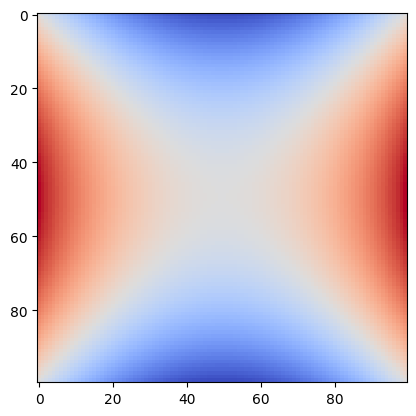

In [6]:
# Neumann boundary conditions

def first_difference(dx, degree=2):
    # Finite difference kernel for the first derivative.
    n = np.arange(degree + 1)
    k = np.arange(degree + 1)[:, None]
    A = n**k / scipy.special.factorial(k)
    b = np.zeros(degree + 1)
    b[1] = 1
    
    return np.linalg.solve(A, b) / dx

def neumann_M(N, degree=2):
    # Create n+1 x n+1 sparse matrix out of stencil and bdry equations
    dx = 1 / (N - 1)
    
    if degree == 2:
        s = five_point_stencil(dx)
    elif degree == 4:
        s = nine_point_stencil(dx)
    else:
        raise Exception("Only have degrees 2 and 4 implemented.")
    
    # Interior points
    offsets = []
    diags = []
    for i in range(s.shape[1]):
        x = i - s.shape[1] // 2
        for j in range(s.shape[0]):
            if s[i, j] == 0:
                continue
            
            y = j - s.shape[0] // 2
            offset = x + N * y
            offsets.append(offset)
            diags.append(np.repeat(s[j, i], N**2 - abs(offset)))
    
    M = scipy.sparse.diags(diags, offsets).tolil()
    
    # Zero out boundaries
    for i in range(N):
        M[i] = 0
        M[i*N] = 0
        M[i*N+N-1] = 0
        M[N**2-N+i] = 0
        
    kernel = first_difference(dx, degree)
    
    # Horizontal boundary conditions
    i = np.arange(len(kernel))
    for x in range(N):
        M[x, x + i*N] += kernel
        M[N**2-N+x, x+N**2-N-i*N] += kernel
    
    # Vertical boundary conditions
    for y in range(N):
        M[y*N, y*N + i] += kernel
        M[y*N+N-1, y*N+N-1-i] += kernel
    
    return M

N = 100
u = np.zeros((N, N))
u[[0, -1], :] += 1
u[:, [0, -1]] -= 1
M = neumann_M(N)

p = scipy.sparse.linalg.spsolve(M, u.flatten())
p = p.reshape((N, N))
plt.imshow(p, cmap="coolwarm")
plt.show()

In [7]:
def trapezoid(u, dt, M, I):
    shape = u.shape
    u = u.flatten()
    return scipy.sparse.linalg.spsolve(I - dt*M/2, M @ u * dt/2 + u).reshape(shape)


N = 21
M = neumann_M(N)
I = scipy.sparse.identity(N**2)

u = np.zeros((N, N))
u[[0, -1], :] += 1
u[:, [0, -1]] -= 1
dt = 1e-2

fig = plt.figure()
im = plt.imshow(u, animated=True, cmap="coolwarm")
im.set_clim(-1, 1)
plt.colorbar()

def updatefig(*args):
    global u
    u = trapezoid(u, dt, M, I)
    
    im.set_array(u)
    return im,

ani = animation.FuncAnimation(fig, updatefig, frames=50, interval=100, blit=False, repeat=False)

html_video = HTML(ani.to_jshtml())
plt.close()
display(html_video)